In [1]:
import warnings, platform, psutil

warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"

### scikit-learn 0.23.2 gives similar (and better) result compared to 0.24.0 for some reason

In [2]:
!pip install scikit-learn==0.23.2

In [3]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.23.2.


In [4]:
import os
import pickle
from collections import Counter

import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from clustering_evaluation import ClusterPurity
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder


In [5]:
evaluator=ClusterPurity()

In [6]:
!pip install easydict

## Load AI4BD embeddings (pickle)

In [7]:
PATH_TRANS_E = "transe_ai4bd_256_1000.pkl"

In [8]:
# transe_ai4bd_256_1000.pkl: pre-trained model of ai4bd with 256 dim. 1000 epoch
with open(PATH_TRANS_E, "rb") as fin:
    model = pickle.load(fin)
    
entity2id = model.graph.entity2id
relation2id = model.graph.relation2id

entity_embeddings = model.solver.entity_embeddings
relation_embeddings = model.solver.relation_embeddings

entity_embeddings.shape

(490806, 256)

In [9]:
# entity2id

In [10]:
fb_train=pd.read_csv('order_stock.train', sep=',',index_col="unique_id")
fb_valid=pd.read_csv('order_stock.valid', sep=',',index_col="unique_id")
fb_test=pd.read_csv('order_stock.test', sep=',',index_col="unique_id")

fb_df=pd.concat([fb_train, fb_valid, fb_test])
# fb_df['type']= fb_df[1].apply(lambda x: x.split('/')[4])

In [11]:
# relation2id


In [12]:
ground_truth={}
for entity_id in entity2id.keys():    
    try:
        if "XXXXXX" in entity_id:
            entity_id_ = entity_id.split("/")[3].replace(">","")

            if entity_id_ in fb_df.index:
                if isinstance(fb_df.loc[entity_id_, 'type'], pd.core.series.Series): 
                    ground_truth[entity_id]=fb_df.loc[entity_id_,"type"].values[0]
                else:
                    ground_truth[entity_id]=fb_df.loc[entity_id_, 'type']
            else:
                continue
                ground_truth[entity_id]='unknown' # for missed types        
    except BaseException as b:
        print(b)
        continue

In [13]:
print(f"Shape of entity_embeddings {entity_embeddings.shape}")
print(f"Type of entitiy_embeddings {type(entity_embeddings)}")
print()
print(f"Unique values of ground_truth {set(ground_truth.values())}")
print(f"Type of ground_truth {type(ground_truth)}")

Shape of entity_embeddings (490806, 256)
Type of entitiy_embeddings <class 'numpy.ndarray'>

Unique values of ground_truth {'stock change', 'order'}
Type of ground_truth <class 'dict'>


In [14]:
# count frequent types in ground_truth
Counter(ground_truth.values()).most_common()

[('order', 56227), ('stock change', 56000)]

In [16]:
#filter top commen types
entity_embedding_filter=[]
y_true_filter=[]

top_types=['order','stock change']
order_counter=1
stock_counter=1
for k, value in ground_truth.items():
    if value in top_types:
        
        if order_counter >= 28_000 and value=="order":
            continue
        elif stock_counter >= 28_000 and value=="stock change":
            continue
        else:
            entity_embedding_filter.append(entity_embeddings[entity2id[k]])
            y_true_filter.append(value)
            
        if value == "order":
            order_counter+=1
        elif value=="stock change":
            stock_counter+=1


In [17]:
len(entity_embedding_filter)

55998

In [18]:
X_all = np.asarray(entity_embedding_filter)
X_all.shape

(55998, 256)

In [19]:
encoder = LabelEncoder()
y_all = encoder.fit_transform(y_true_filter)
labels = encoder.classes_.tolist()

## t-SNE Freebase visualization

In [6]:
projection_full = TSNE(random_state=42).fit_transform(X_all)

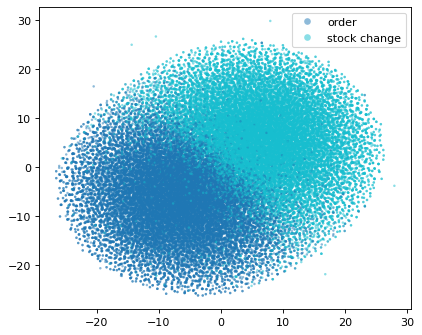

In [7]:
plt.figure(figsize=(6, 5), dpi=80)
scatter = plt.scatter(projection_full[:, 0], projection_full[:, 1], s=5,  cmap='tab10', c=y_all, linewidth=0, alpha=0.5) 

handles, _ = scatter.legend_elements(prop='colors')
plt.legend(handles, labels)

plt.savefig('./tsne_files/transe/ai4bd-transE-full.pdf', dpi=100)

# Unsupervised

## HDBSCAN

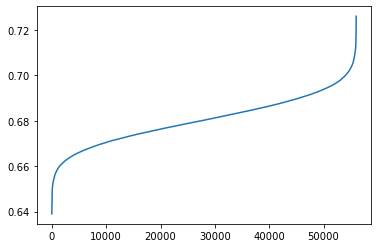

In [30]:
# final optimal value for cluster epsilon
neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(X_all)
distances, indices = nbrs.kneighbors(X_all)

distances = np.sort(distances, axis=0)
distances = distances[:,-1]
plt.plot(distances)

In [20]:
X_all_double=X_all.astype(np.double)

In [23]:
%%time
hdbscan_clusterer=hdbscan.HDBSCAN(algorithm='best', alpha=1.3, cluster_selection_method='leaf',
                                      min_samples=2, min_cluster_size=1000, core_dist_n_jobs=-1,allow_single_cluster=False,
                                      cluster_selection_epsilon=0.5)
hdbscan_clusterer.fit(X_all_double)

y_hdbscan=hdbscan_clusterer.labels_

# majority voting per cluster
df_tmp = pd.DataFrame({'pred_hdbscan': y_hdbscan, 'y_all': y_all})
pred_hdbscan = df_tmp.groupby('pred_hdbscan').transform(lambda x: x.mode().iloc[0]).to_numpy().reshape(-1)

CPU times: user 17min 45s, sys: 2.91 s, total: 17min 48s
Wall time: 17min 44s


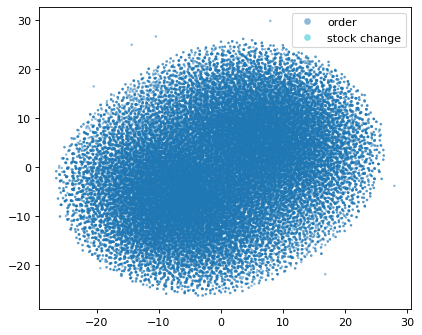

In [10]:
plt.figure(figsize=(6, 5), dpi=80)
plt.scatter(projection_full[:, 0], projection_full[:, 1], s=5,  cmap='tab10', c=pred_hdbscan, linewidth=0, alpha=0.5)

handles, _ = scatter.legend_elements(prop='colors')
plt.legend(handles, labels)
plt.savefig('./tsne_files/transe/ai4bd-transE-hdbscan.pdf', dpi=100)

In [40]:
y_list=y_hdbscan.tolist()
print (y_list.count(0), y_list.count(1), y_list.count(-1))

0 0 55998


In [24]:
accuracy = accuracy_score(y_all, pred_hdbscan)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_all, pred_hdbscan, zero_division=0, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_all, pred_hdbscan, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_all, pred_hdbscan, average='weighted')
print('F1 score: %f' % f1)

print ('Purity: ' , evaluator.purity_score(y_true=y_all, y_pred=pred_hdbscan))

Accuracy: 0.500000
Precision: 0.250000
Recall: 0.500000
F1 score: 0.333333
Purity:  0.5


## Centroid-based Clustering (K-means):

In [25]:
%%time
kmeans = KMeans(n_clusters=len(top_types)).fit(X_all)
pred_kmeans = kmeans.predict(X_all)

# majority voting per cluster
df_tmp = pd.DataFrame({'pred_kmeans': pred_kmeans, 'y_all': y_all})
pred_kmeans = df_tmp.groupby('pred_kmeans').transform(lambda x: x.mode().iloc[0]).to_numpy().reshape(-1)

CPU times: user 29.3 s, sys: 14.1 s, total: 43.4 s
Wall time: 3.85 s


In [26]:
accuracy = accuracy_score(y_all, pred_kmeans)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_all, pred_kmeans, zero_division=0, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_all, pred_kmeans, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_all, pred_kmeans, average='weighted')
print('F1 score: %f' % f1)

print ('Purity: ' , evaluator.purity_score(y_true=y_all, y_pred=pred_kmeans))

Accuracy: 0.986589
Precision: 0.986604
Recall: 0.986589
F1 score: 0.986589
Purity:  0.986588806743098


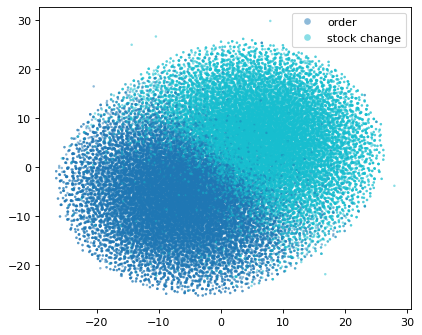

In [12]:
plt.figure(figsize=(6, 5), dpi=80)
plt.scatter(projection_full[:, 0], projection_full[:, 1], s=5,  cmap='tab10', c=pred_kmeans, linewidth=0, alpha=0.5)

handles, _ = scatter.legend_elements(prop='colors')
plt.legend(handles, labels)
plt.savefig('./tsne_files/transe/ai4bd-transE-Kmeans.pdf', dpi=100)

## Agglomerative Clustering:

In [27]:
%%time
aggClustering = AgglomerativeClustering(n_clusters=len(top_types))
y_aggClustering=aggClustering.fit_predict(X_all)

# majority voting per cluster
df_tmp = pd.DataFrame({'pred_agglom': y_aggClustering, 'y_all': y_all})
pred_agglom = df_tmp.groupby('pred_agglom').transform(lambda x: x.mode().iloc[0]).to_numpy().reshape(-1)

CPU times: user 6min 14s, sys: 4.61 s, total: 6min 18s
Wall time: 6min 18s


In [28]:
accuracy = accuracy_score(y_all, pred_agglom)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_all, pred_agglom, zero_division=0, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_all, pred_agglom, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_all, pred_agglom, average='weighted')
print('F1 score: %f' % f1)

print ('Purity: ' , evaluator.purity_score(y_true=y_all, y_pred=pred_agglom))

Accuracy: 0.874656
Precision: 0.874792
Recall: 0.874656
F1 score: 0.874645
Purity:  0.8746562377227758


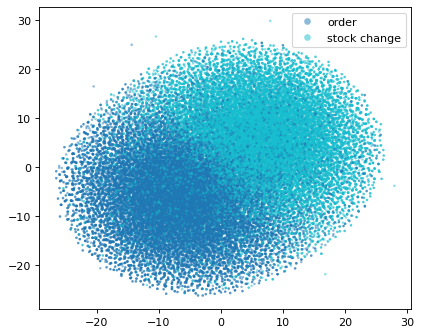

In [14]:
plt.figure(figsize=(6, 5), dpi=80)
plt.scatter(projection_full[:, 0], projection_full[:, 1], s=5,  cmap='tab10', c=pred_agglom, linewidth=0, alpha=0.5)

handles, _ = scatter.legend_elements(prop='colors')
plt.legend(handles, labels)
plt.savefig('./tsne_files/transe/ai4bd-transE-agglom.pdf', dpi=100)

# Supervised Baselines

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.33, random_state=42)

In [16]:
projection_train = TSNE(random_state=42).fit_transform(X_train)
projection_test = TSNE(random_state=42).fit_transform(X_test)

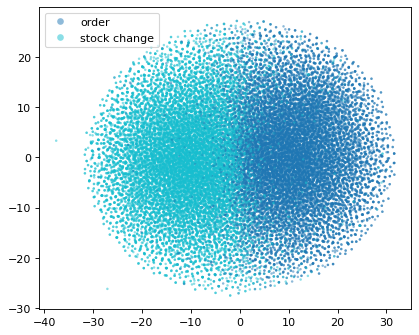

In [18]:
plt.figure(figsize=(6, 5), dpi=80)
scatter = plt.scatter(projection_train[:, 0], projection_train[:, 1], s=5,  cmap='tab10', c=y_train, linewidth=0, alpha=0.5) 

handles, _ = scatter.legend_elements(prop='colors')
plt.legend(handles, labels)

plt.savefig('./tsne_files/transe/ai4bd-transE-train.pdf', dpi=100)

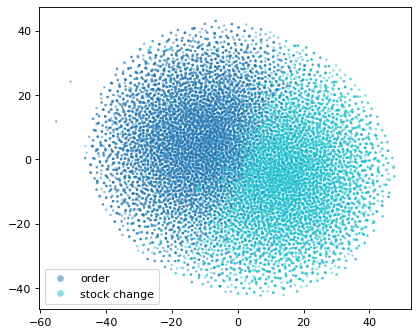

In [19]:
plt.figure(figsize=(6, 5), dpi=80)
scatter = plt.scatter(projection_test[:, 0], projection_test[:, 1], s=5,  cmap='tab10', c=y_test, linewidth=0, alpha=0.5) 

handles, _ = scatter.legend_elements(prop='colors')
plt.legend(handles, labels)

plt.savefig('./tsne_files/transe/ai4bd-transE-test.pdf', dpi=100)

## Logistic Regression:

In [30]:
%%time

from sklearn.linear_model import LogisticRegression
logistic_clf = LogisticRegression(solver='liblinear',random_state=42).fit(X_train, y_train.ravel())
y_lr = logistic_clf.predict(X_test)

CPU times: user 1.29 s, sys: 75.8 ms, total: 1.36 s
Wall time: 1.37 s


In [31]:
#----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(y_test, y_lr)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_test, y_lr, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_test, y_lr, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_test, y_lr, average='weighted')
print('F1 score: %f' % f1)

print('Purity Score: ', evaluator.purity_score(y_true=y_test, y_pred=y_lr))

Accuracy: 0.991937
Precision: 0.991941
Recall: 0.991937
F1 score: 0.991937
Purity Score:  0.9919372294372294


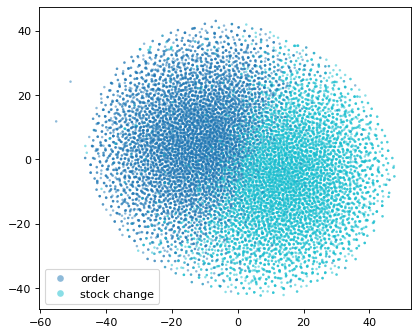

In [21]:
plt.figure(figsize=(6, 5), dpi=80)
plt.scatter(projection_test[:, 0], projection_test[:, 1], s=5,  cmap='tab10', c=y_lr, linewidth=0, alpha=0.5)

handles, _ = scatter.legend_elements(prop='colors')
plt.legend(handles, labels)
plt.savefig('./tsne_files/transe/ai4bd-transE-logistic.pdf', dpi=100)

## KNN:

In [32]:
%%time
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train.ravel())
y_knn = neigh.predict(X_test)

CPU times: user 4min 53s, sys: 23.6 ms, total: 4min 53s
Wall time: 4min 53s


In [33]:
#----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(y_test, y_knn)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_test, y_knn, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_test, y_knn, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_test, y_knn, average='weighted')
print('F1 score: %f' % f1)

print('Purity Score: ', evaluator.purity_score(y_true=y_test, y_pred=y_knn))

Accuracy: 0.835065
Precision: 0.836623
Recall: 0.835065
F1 score: 0.834838
Purity Score:  0.8350649350649351


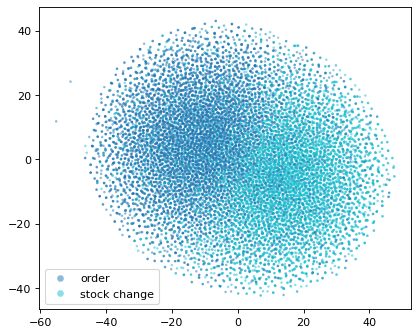

In [23]:
plt.figure(figsize=(6, 5), dpi=80)
plt.scatter(projection_test[:, 0], projection_test[:, 1], s=5,  cmap='tab10', c=y_knn, linewidth=0, alpha=0.5)

handles, _ = scatter.legend_elements(prop='colors')
plt.legend(handles, labels)
plt.savefig('./tsne_files/transe/ai4bd-transE-knn.pdf', dpi=100)

## RandomForest:

In [34]:
%%time
from sklearn.ensemble import RandomForestClassifier

random_clf = RandomForestClassifier(random_state=42).fit(X_train, y_train.ravel())
y_rf= random_clf.predict(X_test)

CPU times: user 1min 22s, sys: 27.9 ms, total: 1min 22s
Wall time: 1min 22s


In [35]:
#----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(y_test, y_rf)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_test, y_rf, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_test, y_rf, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_test, y_rf, average='weighted')
print('F1 score: %f' % f1)

print('Purity Score: ', evaluator.purity_score(y_true=y_test, y_pred=y_rf))

Accuracy: 0.993831
Precision: 0.993833
Recall: 0.993831
F1 score: 0.993831
Purity Score:  0.9938311688311688


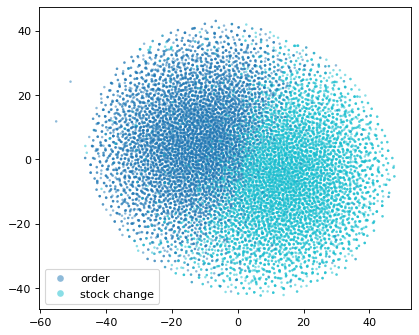

In [25]:
plt.figure(figsize=(6, 5), dpi=80)
plt.scatter(projection_test[:, 0], projection_test[:, 1], s=5,  cmap='tab10', c=y_rf, linewidth=0, alpha=0.5)

handles, _ = scatter.legend_elements(prop='colors')
plt.legend(handles, labels)
plt.savefig('./tsne_files/transe/ai4bd-transE-RandomForest.pdf', dpi=100)

## Random Clustering:

In [36]:
y_random=np.random.choice([0, 1,2,3,4,5], size=y_all.shape[0])

In [37]:
#----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(y_all, y_random)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_all, y_random, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_all, y_random, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_all, y_random, average='weighted')
print('F1 score: %f' % f1)
print ('Purity: ' , evaluator.purity_score(y_true=y_all, y_pred=y_random))

Accuracy: 0.167327
Precision: 0.502799
Recall: 0.167327
F1 score: 0.251091
Purity:  0.5065716632736883


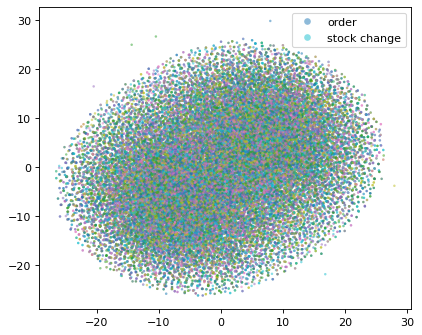

In [27]:
plt.figure(figsize=(6, 5), dpi=80)
plt.scatter(projection_full[:, 0], projection_full[:, 1], s=5,  cmap='tab10', c=y_random, linewidth=0, alpha=0.5)

handles, _ = scatter.legend_elements(prop='colors')
plt.legend(handles, labels)
plt.savefig('./tsne_files/transe/ai4bd-transE-random.pdf', dpi=100)

## Random Clustering based on Type Distribution:

In [38]:
weights=[]
y_counts=Counter(y_all)

for i in range(len(top_types)):
    weights.append(y_counts[i]/y_all.shape[0])
    
weights

[0.5, 0.5]

In [46]:
y_random_bala=np.random.choice([0,1], size=y_all.shape[0], p=weights)

In [47]:
#----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(y_all, y_random_bala)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_all, y_random_bala, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_all, y_random_bala, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_all, y_random_bala, average='weighted')
print('F1 score: %f' % f1)
print ('Purity: ' , evaluator.purity_score(y_true=y_all, y_pred=y_random_bala))

Accuracy: 0.498554
Precision: 0.498554
Recall: 0.498554
F1 score: 0.498553
Purity:  0.5014464802314368


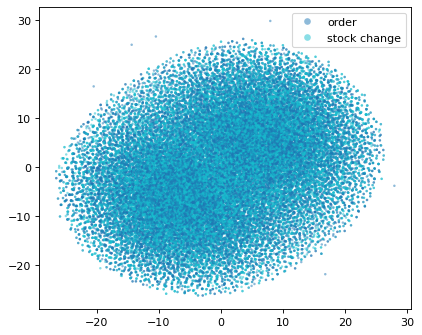

In [29]:
plt.figure(figsize=(6, 5), dpi=80)
plt.scatter(projection_full[:, 0], projection_full[:, 1], s=5,  cmap='tab10', c=y_random_bala, linewidth=0, alpha=0.5)

handles, _ = scatter.legend_elements(prop='colors')
plt.legend(handles, labels)
plt.savefig('./tsne_files/transe/ai4bd-transE-randomBala.pdf', dpi=100)